# A brief COMAP fits map tutorial

In this quick tutorial, we will have a look at how the COMAP map files look, what they contain and how to access and plot the data contained in them.

The maps come in the commonly used `fits` file format and it is here assumed that you have astropy or any other packages for `fits` file handling installed already. We will here show how to access and plot the data using `astropy`, `matplotlib` and `numpy` in python.

The COMAP collaboration has provided you with three maps; `field1_map.fits`, `field2_map.fits` and `field3_map.fits`, which respectively contain the first season COMAP maps of type constant elevation scans (CES) for each of our three fields coadded over all detectors.

We note that since the maps we provide are in the `fits` format you can of course open them with any `fits` compatible software like SAOImageDS9, but that is not shown here. 

Lets start by importing the modules needed to open and visialize the COMAP season 1 (S1) maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS


Using `astropy`'s `io` module we can simply open the map by the following commands  

In [2]:
filename_field2 = "field2_map.fits"
hdul = fits.open(filename_field2)

To display a summary of the files content we can use the `HDUList.info()` function

In [3]:
hdul.info()

Filename: field2_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  MAP_FULL      1 ImageHDU        31   (120, 120, 256)   float32   
  2  NHIT_FULL     1 ImageHDU        30   (120, 120, 256)   int64   
  3  SIGMA_WN_FULL    1 ImageHDU        31   (120, 120, 256)   float32   


As we can see, the map `fits` file contains three HDUs of data; 
* The map 
* The hit map
* The noise level map 

each with $120\times 120$ pixels in RA/Dec for 256 frequency channels

As usual with `fits` maps we have stored the World Coordinate System (WCS) information that defines the maps geometry in the HDU headers. To display the header, simply access a given HDU's header attribute;

In [4]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  120                                                  
NAXIS2  =                  120                                                  
NAXIS3  =                  256                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 60.5 / Pixel coordinate of reference point            
CRPIX2  =              -1514.5 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =   -0.0547559877234

and similarly for the other HDU's. 

Further more, one can access the fits header as a python dictionary to extract any parameter from the header, e.g.

In [5]:
map_unit = hdul[1].header["BUNIT"]
crpix1 = hdul[1].header["CRPIX1"]
print(map_unit, crpix1)

K 60.5


To open the image data from one of the HDUs we can use its `data` attribute

In [6]:
mapdata = hdul[1].data * u.Unit(map_unit)

Next let's use the header of the first HDU to define an `astropy WCS` object that we can use to interface with `matplotlib` in order to illustrate our map

In [7]:
wcs = WCS(hdul[1].header)
print(wcs)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---CAR'  'DEC--CAR'  'FREQ'  
CRVAL : 170.0  0.0  26015625000.0  
CRPIX : 60.5  -1514.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.054755987723486  0.033333333333333  31250000.0  
NAXIS : 120  120  256


Lets now define a function that takes in one of the HDUs from the file and a chosen frequency channel, and plots the map from the HDU at the given channel:

In [8]:
# For visual purposes lets mask regions with high noise at the field edges
for i in range(1, 4):
    hdul[i].data = np.where(hdul[3].data * u.Unit(map_unit) < 1000 * u.uK, hdul[i].data, np.nan)

In [9]:
def plot_map(hdu, channel):
    """Function that takes in a 3D map and a frequency channel, and subsequently
    plots the map at the provided frequency slice.
    
    Args:
        hdu (astropy.io.fits.hdu.image.ImageHDU): Some HDU with map data
        to compute the pixel-feed index.
        channel (int): Integer index corresponding to the frequency channel we want to display.
    """
    fig = plt.figure(figsize = (8, 8))
    
    
    # Extract data from HDU
    plotdata = hdu.data
    
    # Change units from Kelvin to micro Kelvin if provided HDU contains map or noise level map.
    if hdu.header["EXTNAME"] == 'MAP_FULL':
        plotdata = (plotdata[channel, :, :] * u.Unit(map_unit)).to(u.uK).value
        # Upper and lower color limits
        ulim = 2 * np.nanstd(plotdata[40:80, 40:80])
        llim = -ulim
           
        # Define color map
        cmap = mpl.cm.get_cmap('RdBu_r').copy()
        cmap.set_bad(color='gray', alpha = 0.8)
    elif hdu.header["EXTNAME"] == 'SIGMA_WN_FULL':
        plotdata = (plotdata[channel, :, :]* u.Unit(map_unit)).to(u.uK).value
        # Upper and lower color limits
        ulim = np.nanmax(plotdata[40:80, 40:80])
        llim = 0

        # Define color map
        cmap = mpl.cm.get_cmap('CMRmap').copy()
        cmap.set_bad(color='gray', alpha = 0.8)
    else:
        plotdata = plotdata[channel, :, :]
        # Upper and lower color limits
        ulim = np.nanmax(plotdata[20:100, 20:100])
        llim = 0
        
        # Define color map
        cmap = mpl.cm.get_cmap('CMRmap').copy()
        cmap.set_bad(color='gray', alpha = 0.8)

    
    # Define matplotlib axis with WCS object from file.
    # As we are working with a 3D map we also need to provide a slice.
    wcs = WCS(hdul[1].header)
    ax = plt.subplot(projection = wcs, slices=('x', 'y', channel))

    # Plotting the map frequency slice image
    im = ax.imshow(
        plotdata, 
        vmin = llim, 
        vmax = ulim, 
        cmap = cmap, 
        origin = "lower",
    )

    # Let's overlay a nicely formatted coordinate system
    ax.coords.grid(True, color = 'lightgray', ls = 'solid', lw = 1, alpha = 0.4)
    ax.coords[0].set_axislabel('Right Ascension (J2000)')
    ax.coords[0].set_major_formatter('d.ddd')
    ax.coords[0].set_ticks(spacing=20 * u.arcmin, color='white')
    ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation = 90, pad = 35)

    ax.coords[1].set_axislabel('Declination (J2000)')
    ax.coords[1].set_major_formatter('d.ddd')
    ax.coords[1].set_ticks(spacing=20 * u.arcmin, color='white')
    ax.coords[1].set_ticklabel(exclude_overlapping=True)

    # Adding a color bar
    cbaxes = inset_axes(ax, width="2%", height="100%", loc = "right", borderpad = -1) 
    cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
    if hdu.header["EXTNAME"] == 'MAP_FULL' or hdu.header["EXTNAME"] == 'SIGMA_WN_FULL':
        cbar.set_label(r"$\mathrm{\mu K}$")
    else:
        cbar.set_label(r"# hits")

    # You can crop the field of view
    ax.set_xlim(20, 100)
    ax.set_ylim(20, 100)
    
    # Add informative title
    
    frequency = wcs.pixel_to_world(0, 0, channel)[-1].to(u.GHz)    
    print(frequency)
    ax.set_title(f'{hdu.header["EXTNAME"]} at channel {channel} corresponding to {frequency:.3f}')

28.046875 GHz


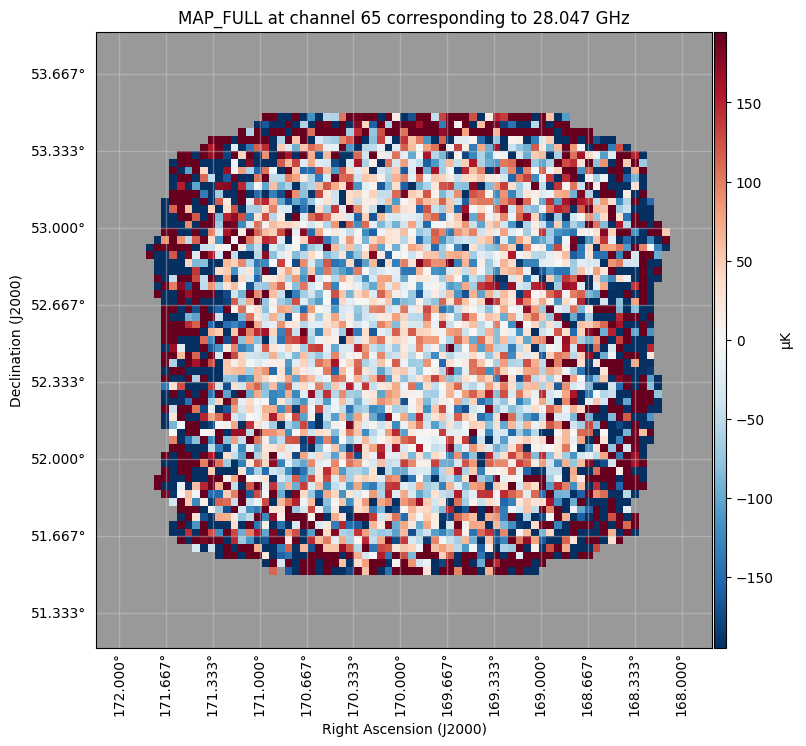

In [10]:
channel = 65 # Here we just use an arbritrary frequency channel

plot_map(hdu = hdul[1], channel = channel) # plot map dataset

Similartly, we can plot the number of hits and the white noise level in each pixel and any frequency by using respectively the second and third HDUs:

28.046875 GHz
28.046875 GHz


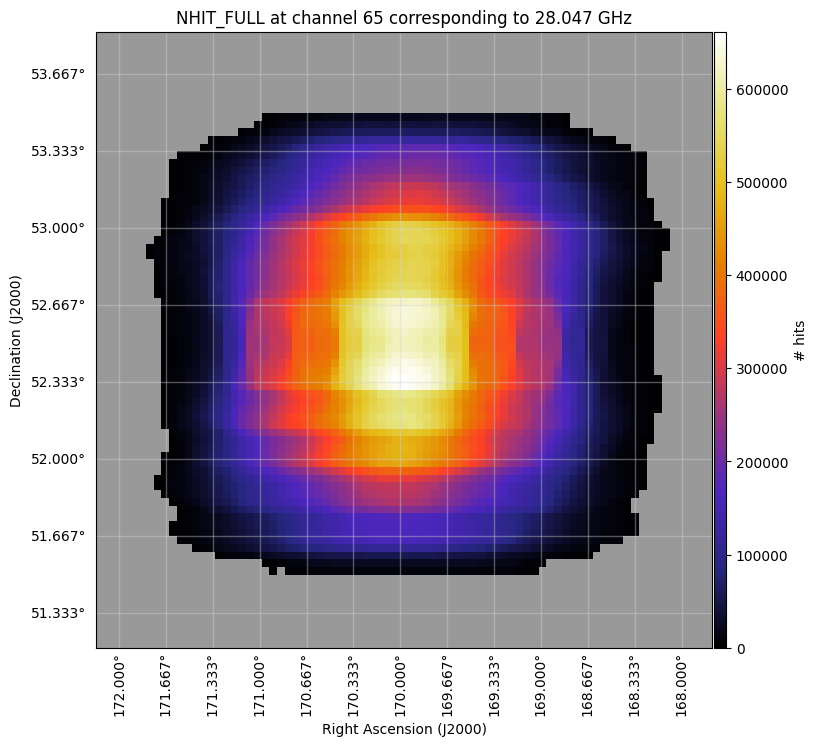

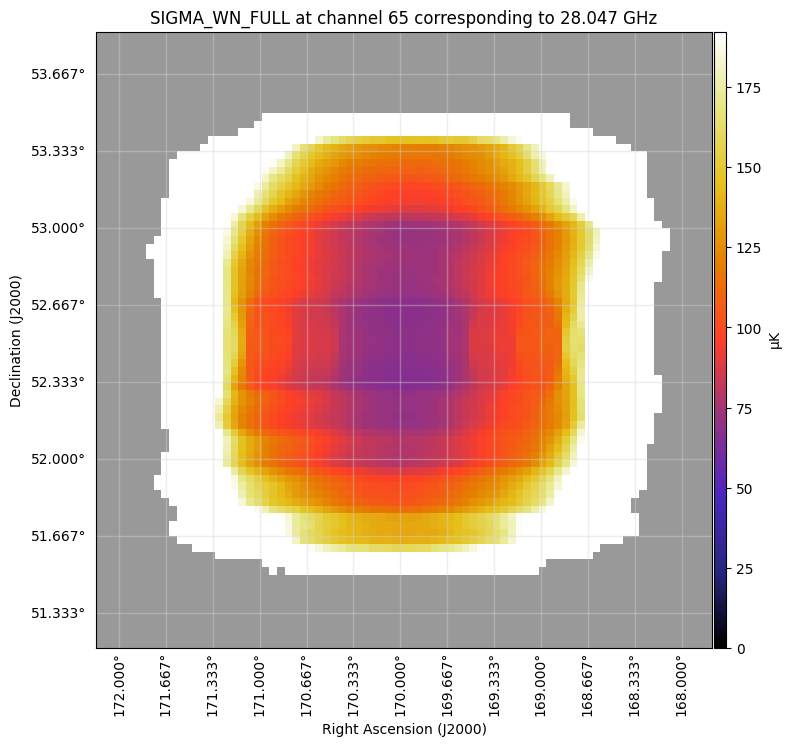

In [11]:
plot_map(hdu = hdul[2], channel = channel) # plot hit dataset
plot_map(hdu = hdul[3], channel = channel) # plot sigma_wn dataset

If you need access to the coordinates of a given voxel you can use the `pixel_to_world` method of the WCS object:

In [12]:
ra_index, dec_index, channel_index = 23, 74, 137
world_coordinate = wcs.pixel_to_world(ra_index, dec_index, channel_index)
print(world_coordinate)

[<SkyCoord (ICRS): (ra, dec) in deg
    (171.99859355, 52.98333333)>, <SpectralCoord 
   (target: <ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
                (170., 0., 1000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 0.)>)
  3.0296875e+10 Hz>]


Make sure to close the file again at the end:

In [13]:
hdul.close()

Alternatively, one can also open the file inside a `with`-block, in which case one does not need to end with a `close` statement, e.g.

In [14]:
with fits.open(filename_field2) as hdul:
    print(hdul.info())

Filename: field2_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  MAP_FULL      1 ImageHDU        31   (120, 120, 256)   float32   
  2  NHIT_FULL     1 ImageHDU        30   (120, 120, 256)   int64   
  3  SIGMA_WN_FULL    1 ImageHDU        31   (120, 120, 256)   float32   
None


### Some things to note

You may have noticed that there are some NaNs in the `MAP_FULL` HDU dataset and infs in the `SIGMA_WN_FULL` HDU dataset. These are used to mask the regions where the COMAP telescope has not observed the sky (hence where the hit map is set to zero). These regions are set to a gray background color in the above plots. 

Furthermore, you may notice how the high-hit regions in the map center nicely corresponds to the low-noise regions in the map and noise maps where we have the highest integration time. 

## The transfer function
When computing power spectra from the COMAP S1 maps it is important to note that the maps themselves are biased. That is due to the COMAP data having been filtered, the telescope beam smoothing the maps and that the data has been downsampled in frequency (see [Foss et al. 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac63ca) and [Ihle et al. 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac63c5)). The biasing effect can in power spectrum space be quantified as a transfer function $T(\vec{k})$ so that the measured power spectrum is given as
$$
P_\mathrm{measured}(\vec{k}) = T(\vec{k})P_\mathrm{unbiased}(\vec{k}).
$$

We have provided the power spectrum transfer function in $\vec{k} = (k_\parallel, k_\perp$) space in a simple ASCII file. Let's have a look at how to open and plot it in the following.

In [15]:
# Load transfer function from ASCII file into numpy array
transfer_func = np.loadtxt("full_tf_CES.txt")

# Load k-space bin edges from ASCII file into numpy array
k_par_edges = np.loadtxt("k_par_bin_edges.txt")
k_perp_edges = np.loadtxt("k_perp_bin_edges.txt")

# Load k-space bin centers from ASCII file into numpy array
k_2D = np.loadtxt("k_2D.txt")
k_par, k_perp = k_2D

Text(0, 0.5, '$k_{\\bot}$ [Mpc$^{-1}$]')

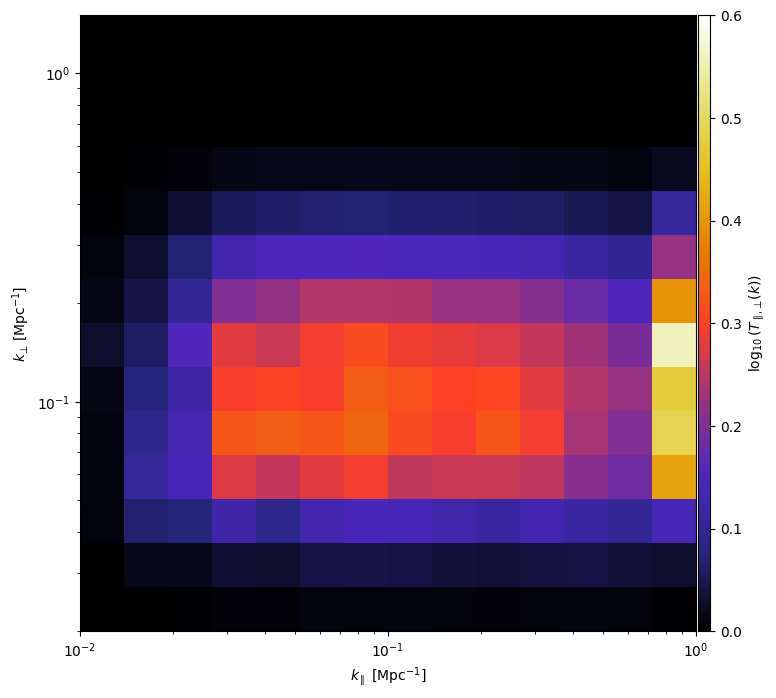

In [16]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plotting transfer function matrix
im = ax.imshow(
    transfer_func,
    origin = "lower",
    vmin = 0,
    vmax = 0.6,
    cmap = "CMRmap",
    extent = [0, 1, 0, 1],
)

# Making a nice colorbar
cbaxes = inset_axes(ax, width="2%", height="100%", loc = "right", borderpad = -1) 
cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
cbar.set_label(r'$\log_{10}(T_{\parallel, \bot}(k))$')

def log2lin(x, k_edges):
    """Function that defines k-bin centers from k-bin edges"""
    
    loglen = np.log10(k_edges[-1]) - np.log10(k_edges[0])
    logx = np.log10(x) - np.log10(k_edges[0])
    return logx / loglen

# List of minor ticks
minorticks = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
              0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
              0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
              0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
              2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
              20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0,
              200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]

# List of major ticks and corresponding labels
majorticks = [1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]
majorlabels = ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$']

# Generating major ticks for plot
xbins = k_par_edges
ticklist_x = log2lin(minorticks, xbins)
majorlist_x = log2lin(majorticks, xbins)
ybins = k_perp_edges
ticklist_y = log2lin(minorticks, ybins)
majorlist_y = log2lin(majorticks, ybins)

# Setting ticks and ticklabels
ax.set_xticks(ticklist_x, minor=True)
ax.set_xticks(majorlist_x, minor=False)
ax.set_xticklabels(majorlabels, minor=False)
ax.set_yticks(ticklist_y, minor=True)
ax.set_yticks(majorlist_y, minor=False)
ax.set_yticklabels(majorlabels, minor=False)

# Only want to look at the part of the plot with the image
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


# Setting axis labels
ax.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax.set_ylabel(r'$k_{\bot}$ [Mpc$^{-1}$]')



### Questions or comments?

Hopefully this brief tutorial was useful for you. If you have any questions or comments regarding this tutorial or the COMAP data in general please do not hesitate to contact the COMAP data analysis team at

#### Nils-Ole Stutzer<br>
PhD student and author of this notebook <br>
E-mail: n.o.stutzer@astro.uio.no  <br>

#### Håvard Tveit Ihle <br>
Postdoc leading the Oslo COMAP data analysis team<br>
E-mail: h.t.ihle@astro.uio.no<br>

#### Jonas Lunde<br>
PhD student <br>
E-mail: j.g.s.lunde@astro.uio.no<br>